In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from src.utils import *
from src.loss import *
from src.model import *
from src.dataset import *

In [2]:
im_left_dir=glob.glob("data/left_imgs/*/*")
im_right_dir = glob.glob("data/right_imgs/*/*")
gt_left_dir=glob.glob("data/left_gt/*/*")
gt_right_dir=glob.glob("data/right_gt/*/*")

kitti_ds = KittiStereoLidar(
    im_left_dir=im_left_dir, 
    im_right_dir=im_right_dir,
    gt_left_dir=gt_left_dir, 
    gt_right_dir=gt_right_dir,
    transform=transforms.Compose([transforms.Resize((197,645)),
                                  transforms.ToTensor()])
)

# Resize issues
# Original(375,1242)
# (389,1285)->(384, 1280)->(160,320)
# (197,645)->(192,640)->(96,320)

In [3]:
batch_size = 10
train_loader = DataLoader(dataset=kitti_ds, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=4)
 
dataiter = iter(train_loader)

data/right_gt/2011_09_30_drive_0028_sync/0000000257.npy


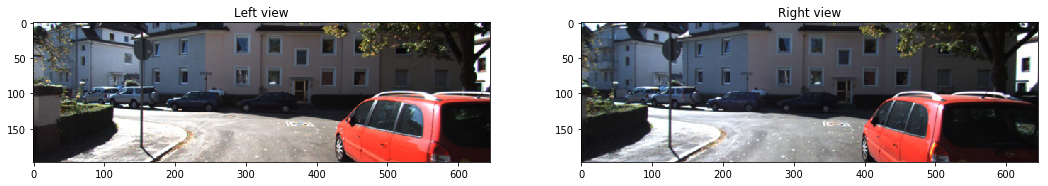

In [4]:
def imshow(iml, imr, scl, scr):
    npl = np.transpose(iml.numpy(), (1,2,0))
    npr = np.transpose(imr.numpy(), (1,2,0))
    f, (ax1, ax2)=plt.subplots(1,2,figsize=(18,6))

    ax1.set_title('Left view')
    ax1.imshow(npl)
    ax2.set_title('Right view')
    ax2.imshow(npr)

images_l, images_r, scans_l, scans_r = dataiter.next()

print(scans_r[5])
scr = np.load(scans_l[5])
scl = np.load(scans_r[5])

imshow(images_l[5], images_r[5], scl, scr)

In [5]:
# Depth prediction networks for left & right view sets respectively
L = Network()
R = Network()

In [6]:
# Dimension test
images_l, images_r, scans_l, scans_r = dataiter.next()
depths_l = L(images_l)

In [7]:
#Precalculate mapping parameters
reconstruct_functions = [Reconstruction(date='2011_09_26'), Reconstruction(date='2011_09_28'),
                         Reconstruction(date='2011_09_29'), Reconstruction(date='2011_09_30'),
                         Reconstruction(date='2011_10_03')]

def normalize_prediction(map_input, scale=100):
    M, m=np.amax(map_input), np.amin(map_input)
    return (map_input - m)*(scale / (M-m))

def get_unsu_loss(depth_maps, src_imgs, tar_imgs, direction, dates):
    
    batch_loss = 0
    for[dep,src,tar,dat] in zip(depth_maps, src_imgs, tar_imgs, dates):
        if dat=='2011_09_26':
            recf = reconstruct_functions[0]
        elif dat=='2011_09_28':
            recf = reconstruct_functions[1]
        elif dat=='2011_09_29':
            recf = reconstruct_functions[2]
        elif dat=='2011_09_30':
            recf = reconstruct_functions[3]
        elif dat=='2011_10_03':
            recf = reconstruct_functions[4]

        # Depth map: transpose-->resize to src-->normalize
        dep = cv2.resize(np.transpose(dep, (1,2,0)).squeeze(), (645,197))
        
        # Source & target image: transpose
        src = np.transpose(src, (1,2,0))
        tar = np.transpose(tar, (1,2,0))
        
        # Calculate sample loss
        sample_loss, _ = recf.compute_loss(dep, src, tar, direction)
        batch_loss += sample_loss

    return round(batch_loss / batch_size, 4)
    
def get_su_loss(depth_maps, scan_files):
    
    batch_loss = 0
    for[dep, scan_file] in zip(depth_maps, scan_files):
        dots = np.load(scan_file)
        dep = cv2.resize(np.transpose(dep, (1,2,0)).squeeze(), (1242,375))
        sample_loss = gt_loss(dep, dots)
        batch_loss += sample_loss
        
    return round(batch_loss / batch_size, 4)
    

In [8]:
# Only detach once
dates = [s[13:23] for s in scans_l]
depths_l = normalize_prediction(depths_l.detach().numpy())
images_l = images_l.detach().numpy()
images_r = images_r.detach().numpy()

In [9]:
# Compute losses respectively
u_loss = get_unsu_loss(depth_maps=depths_l, src_imgs=images_l, tar_imgs=images_r, direction='L2R', dates=dates)
s_loss = get_su_loss(depth_maps=depths_l, scan_files=scans_l)
s_loss, u_loss

(853.0757, 11909.6088)

In [ ]:
L_optimizer = torch.optim.Adam(L.parameters(), lr=lr)
R_optimizer = torch.optim.Adam(R.parameters(), lr=lr)
lr = 0.001
n_epochs = 5

In [ ]:
L.train()
R.train()
n_epochs=1

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    for images_l, images_r, scans_l, scans_r in train_loader: #images_l: torch.Size([batch_size, 3, 197, 645])
        L_optimizer.zero_grad()
        R_optimizer.zero_grad()
        
        # Make depth predictions
        depths_l = L(images_l)
        depths_r = R(images_r)
        
        # To numpy & normalize
        images_l = images_l.detach().numpy()
        images_r = images_r.detach().numpy()
        depths_l = normalize(depth_l.detach().numpy())
        depths_r = normalize(depth_r.detach().numpy())
        
        # Retrieve dates
        drive_dates = [s[13:23] for s in scans_l]
        
        unsu_loss_L2R = get_unsu_loss(depth_maps=depths_l,
                                      src_imgs=images_l,
                                      tar_imgs=images_r,
                                      direction='L2R',
                                      dates=drive_dates)
        unsu_loss_R2L = get_unsu_loss(depth_maps=depths_r,
                                      src_imgs=images_r,
                                      tar_imgs=images_l,
                                      direction='R2L',
                                      dates=drive_dates)
        su_loss_L = get_su_loss(depth_maps=depths_l, scan_files=scans_l)
        su_loss_R = get_su_loss(depth_maps=depths_r, scan_files=scans_r)
        
        """loss.backward()
        
        L_optimizer.step()
        R_optimizer.step()
        train_loss += loss.item()
             
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))"""